# This notebook explores how making multiple measurements of the same system does/does not reduce the uncertainty in the spectra parameters

In [7]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

### Make a fake spectra and get the true counts. Then draw the "observed" counts assuming a Poisson process.

In [8]:
# Spectra parameters
E0t = 100
J0t = 200 

# Reponse parameters
R0 = 1e-2

# Energy array to descritize the spectra and response function
Earr = np.linspace(1, 300, num=1000) 
dE = Earr[1] - Earr[0] # To do the integral.

# Initialize the response function
R = mageis_response.R_gaus()

def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

def true_spectra(Earr, J0t, E0t):
    return spectra(Earr, J0t, E0t)

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(7)
for i in range(7):
    true_lambda[i] = dE*np.dot(true_spectra(Earr, J0t, E0t), 
                               R.response(R0=R0, Earr=Earr, ch=i))

In [9]:
n_obs = [1, 5, 10] # The number of observations to try

In [10]:
np.random.seed(123) # For reproducability.

Run the Bayes model for all of the n_obs number of observations of the same spectra.

In [11]:
def lam(J):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the 7 instrument response functions.
    """
    lams = 7*[None]
    for i in range(c_obs.shape[1]):
        lams[i] = pm.Deterministic(
            'lam{}'.format(i),
            dE*pm.math.dot(J, R.response(R0=R0, Earr=Earr, ch=i))
                              )
    return lams
    
data = {}

for n in n_obs:
    # generate nExn observed counts from the true counts.
    c_obs = np.random.poisson(np.repeat(true_lambda[:, np.newaxis].T, n, axis=0))
    
    # Run the Bayes model.
    m = pm.Model()
    with m:
        # Prior stocastic variables
        J0 = pm.Uniform('J0', lower=1, upper=1E6)
        E0 = pm.Uniform('E0', lower=1, upper=500)

        # Define an exponential spectra
        J = J0*pm.math.exp(-Earr/E0)

        lams = lam(J)
        c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=c_obs.shape)
        trace = pm.sample(1E4, tuning=3000, cores=3)
        
    # Save everything to data dictionary.
    data[n] = {'c_obs':c_obs, 'trace':trace, 'c_m':c_m}
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [E0_interval__, J0_interval__]
 36%|███▋      | 3807/10500.0 [00:08<00:14, 469.38it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '23600' (I am process '23601')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/msshumko/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-redhat-7.5-Maipo-x86_64-3.6.0-64/lock_dir
100%|██████████| 10500/10500.0 [00:21<00:00, 499.21it/s]
The acceptance probability does not match the target. It is 0.888149908965838, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [E0_interval__, J0_interval__]
100%|██████████| 10500/10500.0 [00:24<00:00, 423.35it/s]
The acceptance probability does not match the target. It is 0.9427198217589512, but should 

### Now visualize the distribution of the E0 and J0 traces, and what patten is apparent with more observations

true E0 = 100 keV


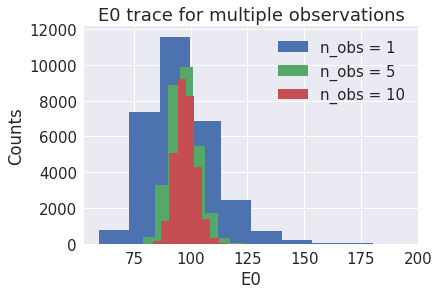

In [29]:
for n in n_obs:
    plt.hist(data[n]['trace']['E0'], label='n_obs = {}'.format(n))
plt.legend(); plt.title('E0 trace for multiple observations'); 
plt.xlabel('E0'); plt.ylabel('Counts');
print('true E0 = {} keV'.format(E0t))

true J0 = 200 keV


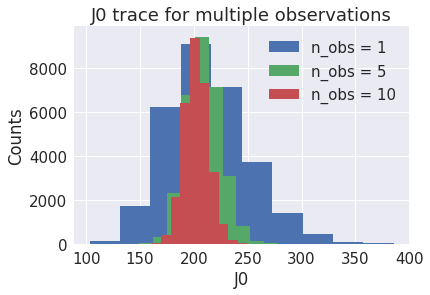

In [30]:
for n in n_obs:
    plt.hist(data[n]['trace']['J0'], label='n_obs = {}'.format(n))
plt.legend(); plt.title('J0 trace for multiple observations'); 
plt.xlabel('J0'); plt.ylabel('Counts');
print('true J0 = {} keV'.format(J0t))